# Módulos

In [7]:
import os # Sistema (arquivos)
import pandas as pd # Tabelas
import sqlite3 # SQL

from datetime import datetime # Datas
import re # Regex

import matplotlib.pyplot as plt # Gráficos

import random # Amostragem aleatória

# Releitura e compactação

## Funções

In [8]:
def agregar_SQLs(pasta, tabela, parse_dates=None):
    dfs = []
    for arquivo in os.listdir(pasta):
        conn = sqlite3.connect(f'{pasta}/{arquivo}')
        dfs.append(pd.read_sql(f'SELECT * FROM {tabela}', conn, parse_dates=parse_dates))
        conn.close()
    return pd.concat(dfs, ignore_index=True).dropna(subset='url').drop_duplicates(subset='url')

def ajustes_gerais(dataframe):
    portais = ['epocanegocios.globo.com', 'globorural.globo.com', 'revistagloborural.globo.com',
               'pipelinevalor.globo.com', 'revistapegn.globo.com', 'umsoplaneta.globo.com', 
               'valor.globo.com', 'valorinveste.globo.com']
    df = dataframe[((dataframe.url.apply(lambda url: url.split('/')[2]).isin(portais)) & 
                    (~dataframe.url.str.contains('?video', regex=False)))].copy()
    return df

In [9]:
data_de_recorte = lambda url: datetime.strptime('/'.join(url.split('_')[-2].split('/')[-3:]), '%Y/%m/%d')

def data_da_url(url):
    if isinstance(url, str):
        match = re.search(r'(\d{4})/(\d{2})/(\d{2})', url)
        if match:
            try:
                return datetime.strptime(match.group(), "%Y/%m/%d") 
            except:
                pass
    return None

## Processo

In [10]:
%%time
# URLs das buscas

urls_das_buscas = agregar_SQLs('bases/buscas', 'urls', ['recorte', 'data'])
urls_das_buscas.columns = ['recorte', 'portal', 'data_da_busca', 'url']
urls_das_buscas = ajustes_gerais(urls_das_buscas)

urls_das_buscas['data_da_url'] = urls_das_buscas.url.apply(data_da_url)
urls_das_buscas.data_da_busca = urls_das_buscas.data_da_busca.dt.date


# URLs dos sitemaps

urls_dos_sitemaps = agregar_SQLs('bases/sitemaps', 'sitemaps')
urls_dos_sitemaps = ajustes_gerais(urls_dos_sitemaps)

urls_dos_sitemaps['recorte'] = urls_dos_sitemaps.sitemap.apply(data_de_recorte)
urls_dos_sitemaps['portal'] = urls_dos_sitemaps.url.apply(lambda url: url.split('/')[2].split('.')[0].replace('revistagloborural', 'globorural'))
urls_dos_sitemaps['data_da_busca'] = pd.to_datetime(urls_dos_sitemaps.data_da_busca.str.slice(0,19))
urls_dos_sitemaps['data_da_url'] = urls_dos_sitemaps.url.apply(data_da_url)

urls_dos_sitemaps = urls_dos_sitemaps[['recorte', 'portal', 'data_da_busca', 'url', 'data_da_url']]
urls_dos_sitemaps.data_da_busca = urls_dos_sitemaps.data_da_busca.dt.date

CPU times: total: 54.7 s
Wall time: 55.5 s


In [11]:
%%time
# Concatenando as bases de URL
urls_SQL = pd.concat([urls_dos_sitemaps, # Só adicionamos a diferença entre elas, mas ainda removemos duplicatas para garantir.
                      urls_das_buscas[~urls_das_buscas.url.isin(urls_dos_sitemaps.url)]]).drop_duplicates(subset = 'url')

# Para referência futura
urls_das_buscas.to_parquet('bases/urls via buscas.parquet', engine = 'pyarrow', index = False)
urls_dos_sitemaps.to_parquet('bases/urls via sitemaps.parquet', engine = 'pyarrow', index = False)

# Dados oficiais
urls_SQL.to_parquet('bases/urls.parquet', engine = 'pyarrow', index = False)

CPU times: total: 3.73 s
Wall time: 3.81 s


# Vistoria

In [12]:
urls_das_buscas = pd.read_parquet('bases/urls via buscas.parquet')
urls_dos_sitemaps = pd.read_parquet('bases/urls via sitemaps.parquet')

urls_SQL = pd.read_parquet('bases/urls.parquet')

## Contribuição à captação

In [6]:
dfs = [urls_das_buscas, urls_dos_sitemaps, urls_SQL]
contribuições = [df.groupby('portal')['url'].count().sort_values(ascending=False) for df in dfs]

contribuição = pd.concat(contribuições, axis=1)
contribuição.columns = ['A', 'B', 'C'] # Colunas provisórias.
referência = contribuição[['C']].copy() # Para a subseção a seguir.

contribuição[['A','B']] = (contribuição[['A','B']].div(contribuição['C'], axis = 0) * 100).map(lambda x: f'{x:.2f}%'.replace('.',','))
contribuição['C'] = contribuição['C'].map('{:,}'.format).str.replace(',', '.')
contribuição.columns = ['% via busca', 
                        '% via sitemap', 
                        'nº de URLs'] # Reais colunas.
contribuição

,% via busca,% via sitemap,nº de URLs
portal,,,
valor,"90,24%","100,00%",822.560
epocanegocios,"99,18%","17,01%",195.211
valorinveste,"97,16%","100,00%",85.225
revistapegn,"98,46%","20,10%",76.253
globorural,"96,96%","99,93%",57.900
umsoplaneta,"94,50%","100,00%",13.165
pipelinevalor,"94,21%","100,00%",4.643


## Frequência de notícias

In [34]:
frequência = referência.copy()
frequência.columns = ['nº de notícias']
frequência['freq. diária'] = frequência['nº de notícias'] / urls_SQL.groupby(by = ['portal']).nunique().recorte
frequência['freq. mensal'] = frequência['freq. diária']*30
frequência.loc['total'] = frequência.sum()
frequência.map(lambda x: f"{int(x):,}".replace(',','.'))

,nº de notícias,freq. diária,freq. mensal
portal,,,
valor,822.560,166,4.991
epocanegocios,195.211,42,1.265
valorinveste,85.225,39,1.194
revistapegn,76.253,19,578
globorural,57.900,15,471
umsoplaneta,13.165,9,275
pipelinevalor,4.643,3,107
total,1.254.957,296,8.884


## Frequência no tempo

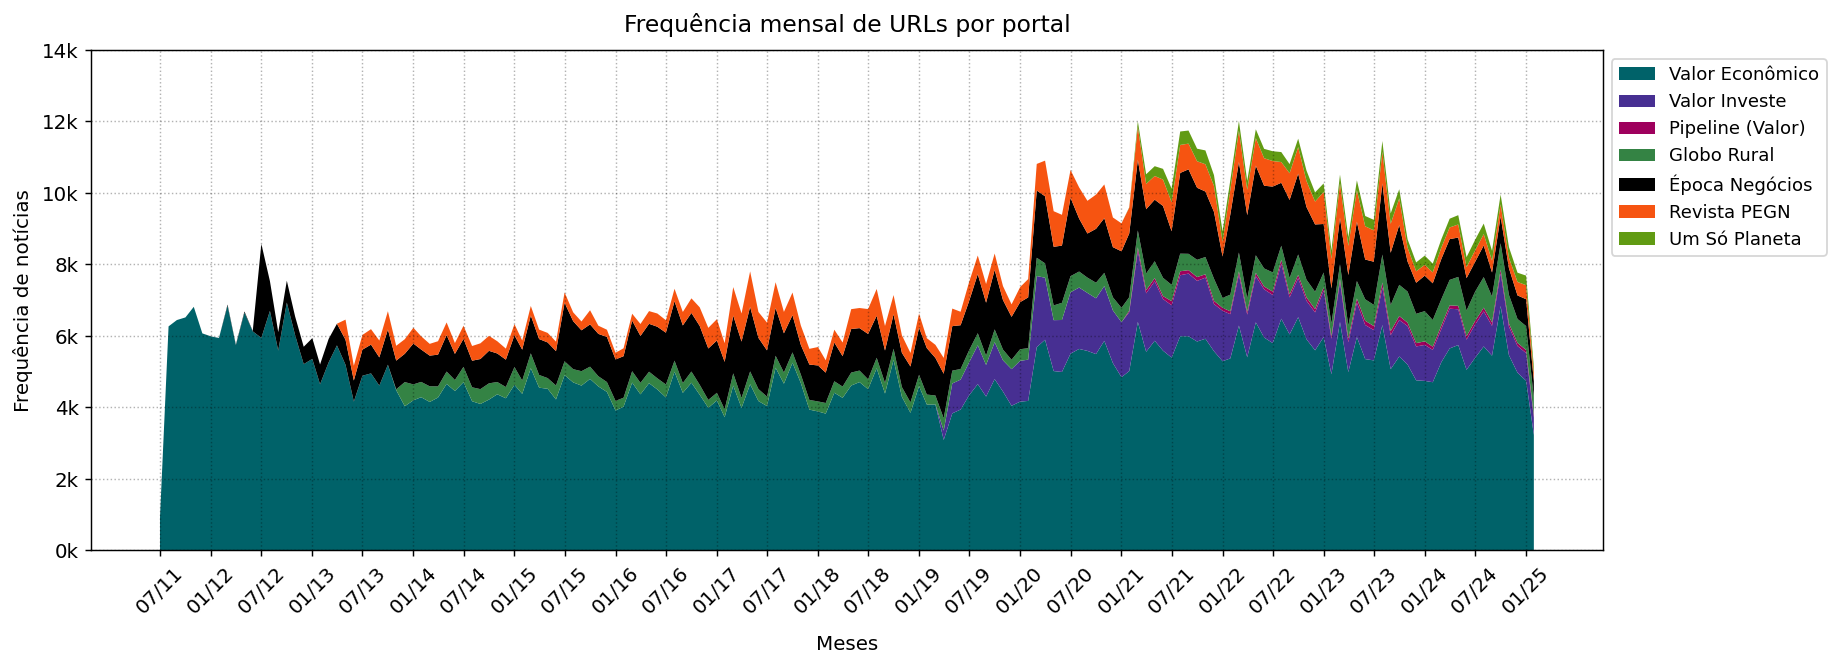

In [35]:
nomes = ['Valor Econômico',
         'Valor Investe',
         'Pipeline (Valor)',
         'Globo Rural',
         'Época Negócios',
         'Revista PEGN',
         'Um Só Planeta']

cores = {
    
    'valor': (0/255, 98/255, 105/255),
    'valorinveste': (71/255, 47/255, 146/255),
    'pipelinevalor': (158/255, 0/255, 93/255),
    'globorural': (52/255, 131/255, 68/255),
    'epocanegocios': (0/255, 0/255, 0/255),
    'revistapegn': (246/255, 84/255, 17/255),
    'umsoplaneta': (97/255, 155/255, 19/255)
    
}

portais = urls_SQL.groupby(['portal', 'recorte']).count().url.unstack().fillna(0)

portais = portais.T
portais.index = pd.to_datetime(portais.index)
portais = portais.resample('ME').sum()  # Agrupando por mês
portais = portais[cores.keys()]


fig, ax = plt.subplots(figsize = (15, 5), dpi = 130)
ax.stackplot(portais.index, portais.T, labels = nomes, colors = cores.values())

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_title("Frequência mensal de URLs por portal", pad = 10, fontsize = 13)

plt.grid(linestyle = ':', color = 'black', alpha = .3)


plt.ylabel('Frequência de notícias', fontsize = 11, labelpad = 5)
yticks = plt.yticks()[0]
plt.yticks(yticks, list(map(lambda y: f'{y/1000:.0f}k', yticks)), fontsize = 11)

plt.xlabel('Meses', labelpad = 10, fontsize = 11)
indices_semestrais = portais.index[::6]
rotulos_semestrais = [f"{dt.month:02d}/{dt.year % 100:02d}" for dt in indices_semestrais]
plt.xticks(indices_semestrais, rotulos_semestrais, rotation = 45, fontsize = 11)

plt.show()

## Comparação c/ Cardoso e Nakane (2024)

In [6]:
pct = urls_SQL[(urls_SQL.portal == 'valor')&(urls_SQL.data_da_url < datetime(2023,1,1))].shape[0]/678616
print(f'Obteve-se {100*pct:.2f}% notícias do montante obtido por Cardoso...')

Obteve-se 98.71% notícias do montante obtido por Cardoso...


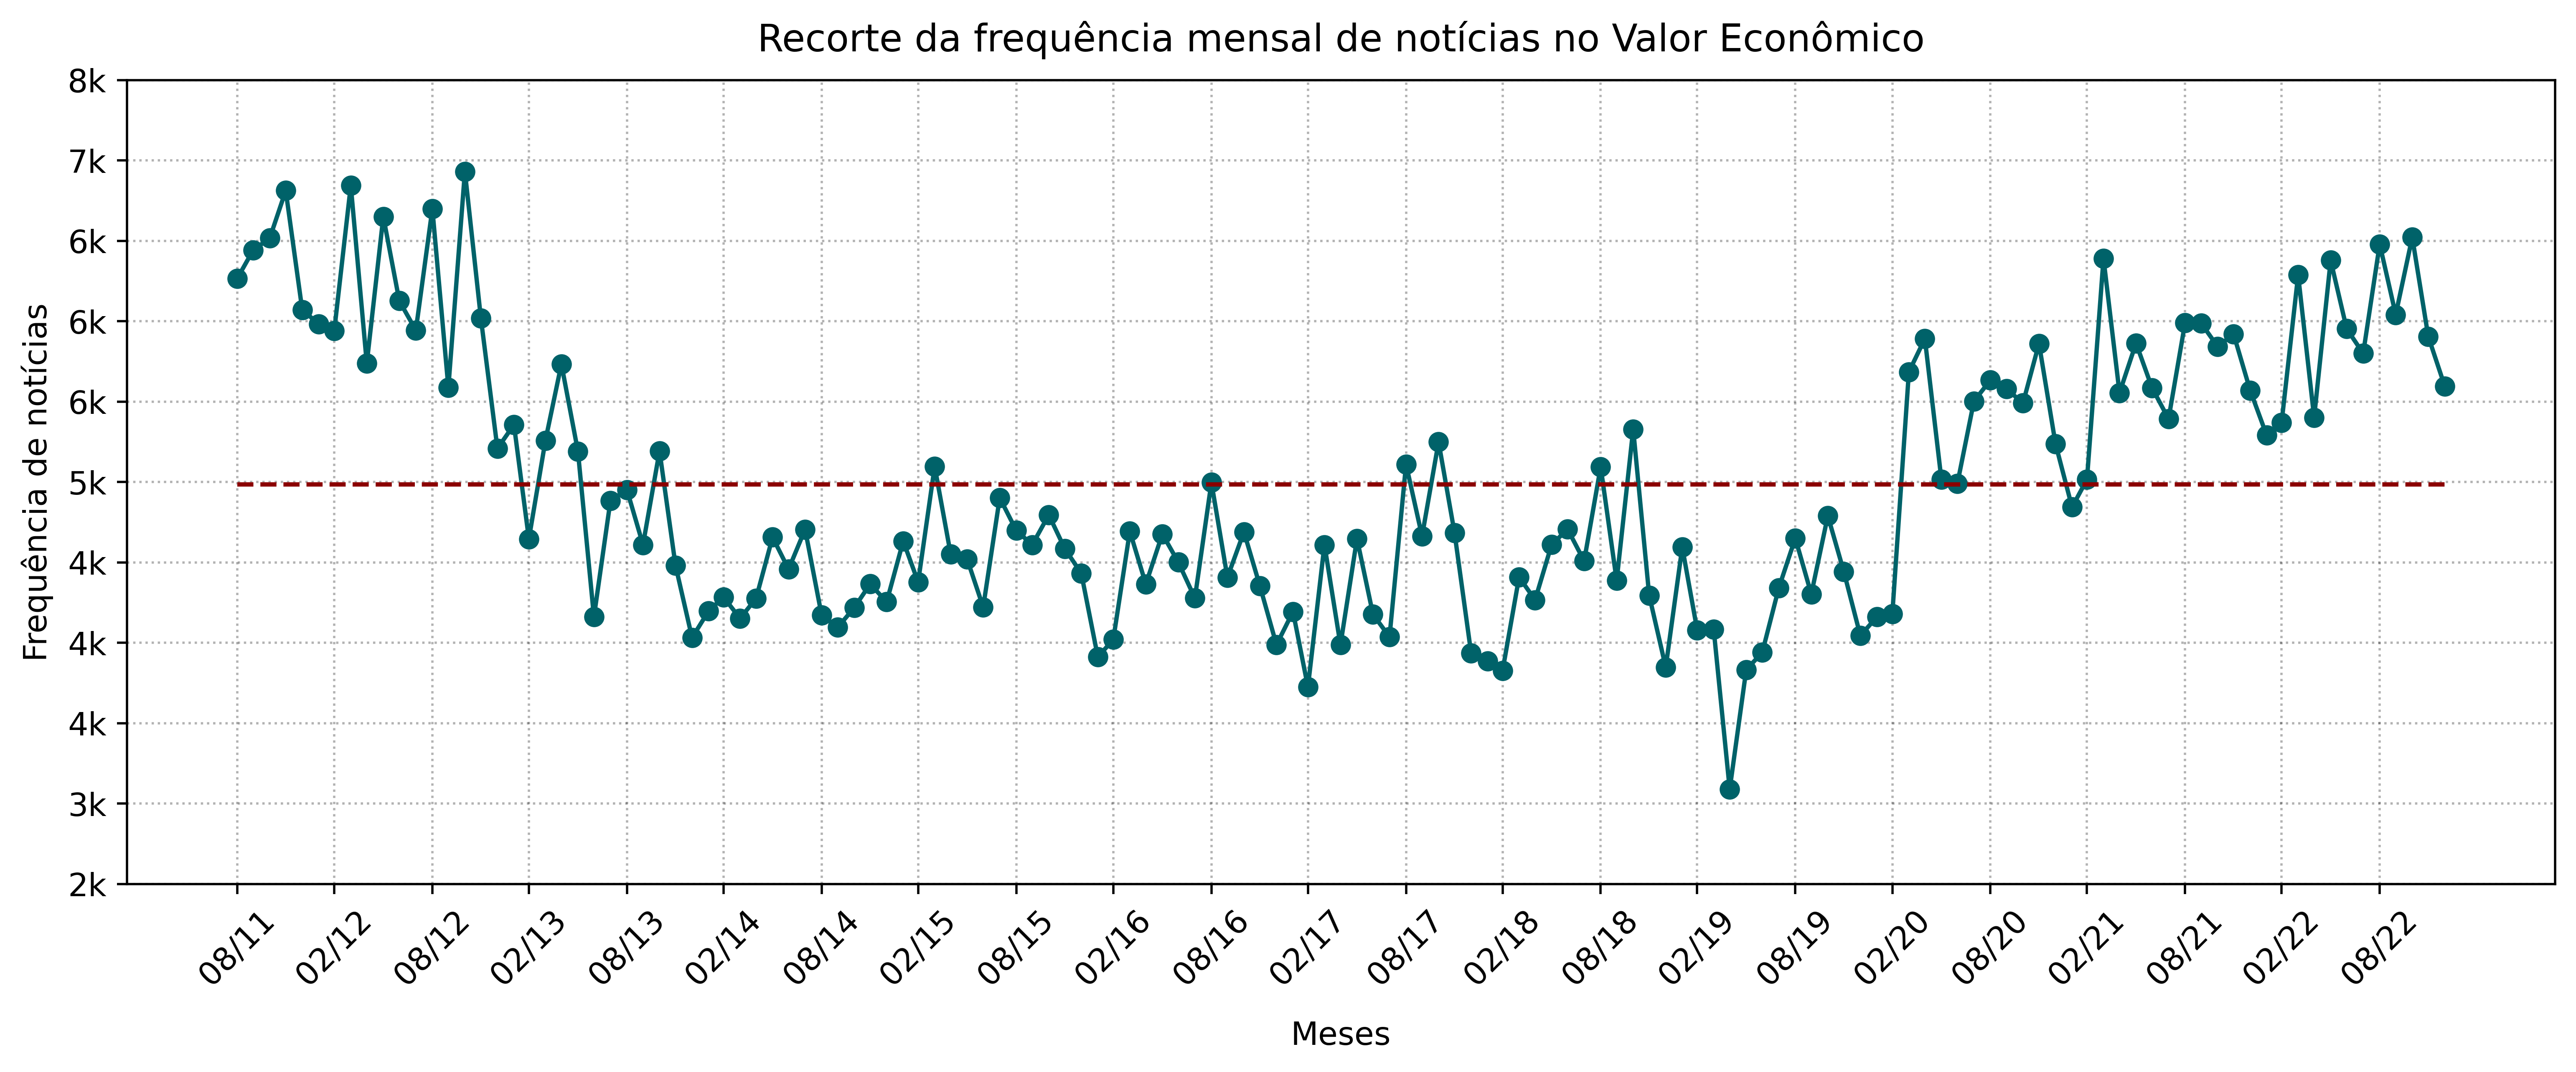

In [22]:
portais = urls_SQL.groupby(['portal', 'recorte']).count().url.unstack().fillna(0)

portais = portais.T
portais.index = pd.to_datetime(portais.index)
portais = portais.resample('ME').sum()  # Agrupando por mês
portais = portais['valor valorinveste pipelinevalor globorural epocanegocios revistapegn umsoplaneta'.split()]

cardoso = portais[portais.index < datetime(2023,1,1)].iloc[1:].valor


plt.figure(figsize = (15,5), dpi = 500)
plt.title('Recorte da frequência mensal de notícias no Valor Econômico', fontsize = 13, pad = 10)
plt.plot(cardoso.index, cardoso, color = (0/255, 98/255, 105/255), marker = 'o')
plt.plot(cardoso.index, [cardoso.sum()/len(cardoso)]*len(cardoso), color = 'darkred', linestyle = '--')
#plt.scatter(cardoso.index, cardoso)

plt.grid(linestyle = ':', color = 'black', alpha = .3)

plt.ylabel('Frequência de notícias', fontsize = 11, labelpad = 5)
yticks = plt.yticks()[0]
plt.yticks(yticks, list(map(lambda y: f'{y/1000:.0f}k', yticks)), fontsize = 11)

plt.xlabel('Meses', labelpad = 10, fontsize = 11)
indices_semestrais = cardoso.index[::6]
rotulos_semestrais = [f"{dt.month:02d}/{dt.year % 100:02d}" for dt in indices_semestrais]
plt.xticks(indices_semestrais, rotulos_semestrais, rotation = 45, fontsize = 11)

plt.show()

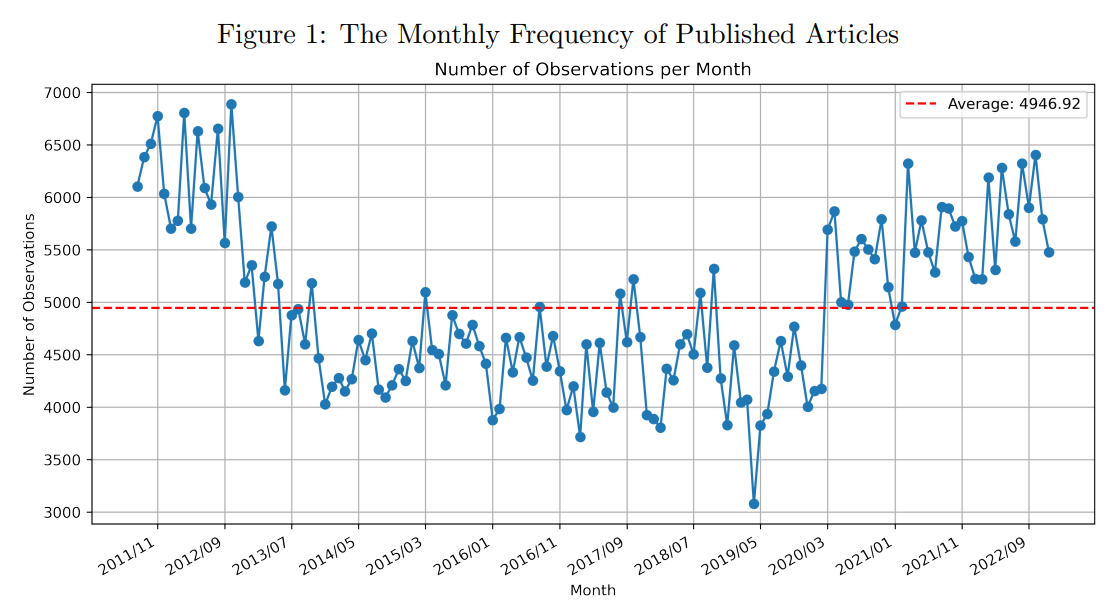

# Verificação das datas

In [8]:
filtro = urls_SQL.recorte == urls_SQL.data_da_url

print(f'{100*filtro.sum()/len(filtro):.2f}% das datas coincidem.')
print(f'Ou seja, {len(filtro)-filtro.sum()} estão "erradas".\n')

diff = (urls_SQL.recorte - urls_SQL.data_da_url).dt.days
print(f'Ademais, o erro médio de {diff.mean():.2f} dias...')

95.53% das datas coincidem.
Ou seja, 56043 estão "erradas".

Ademais, o erro médio de -33.71 dias...


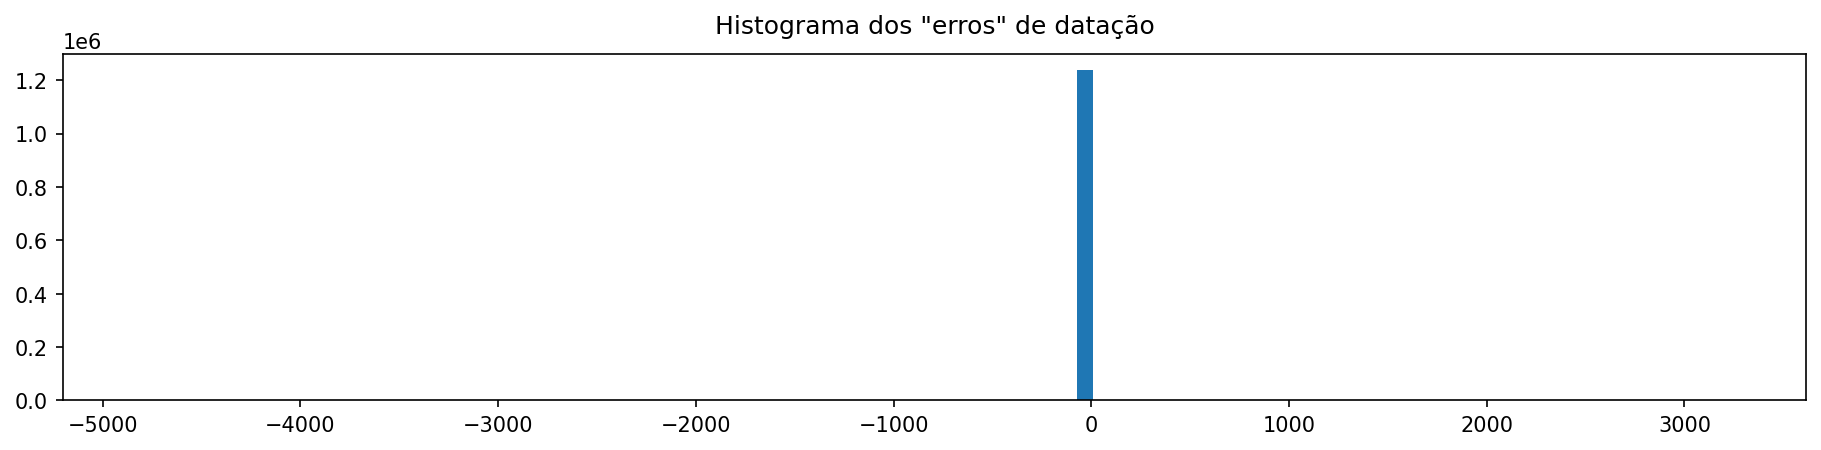

count    56043.000000
mean      -754.852096
std       1369.724490
min      -4801.000000
25%       -765.500000
50%         -1.000000
75%          1.000000
max       3216.000000
dtype: float64

In [23]:
plt.figure(figsize = (15,3), dpi = 150)
plt.title('Histograma dos "erros" de datação', pad = 10)
plt.hist(diff, bins = 100)
plt.show()

diff[~filtro].describe() # Descrição estatísticas do erro.

# Amostragem aleatória

In [18]:
for portal in urls_SQL.portal.dropna().unique():
    print(portal, '\n')
    amostras = urls_SQL[urls_SQL.portal == portal].copy()
    amostras = amostras.iloc[[random.randint(0, len(amostras)) for i in range(5)]].copy()
    for amostra in amostras.iterrows():
        amostra = amostra[1]
        url = amostra.url
        if '.html' in url:
            url = url.split('.html')[0] + '.html'
        if url[:2] == '//':
            print('sem https')
            url = 'https:' + url
        print(amostra.recorte.date(), url)
    print()

epocanegocios 

2023-04-29 https://epocanegocios.globo.com/brasil/noticia/2023/04/funai-avanca-em-reconhecimento-de-terras-krenak-e-munduruku.ghtml
2016-12-27 http://epocanegocios.globo.com/Mercado/noticia/2016/12/epoca-negocios-cvm-quer-que-eike-se-manifeste-sobre-depoimentos-de-testemunhas-no-caso-osx.html
2018-05-26 https://epocanegocios.globo.com/Brasil/noticia/2018/05/epoca-negocios-infraero-falta-combustivel-em-onze-aeroportos-neste-sabado.html
2019-05-20 https://epocanegocios.globo.com/Empresa/noticia/2019/05/epoca-negocios-ryanair-tem-maior-baixa-no-lucro-em-4-anos-empresa-diz-que-pode-cair-mais.html
2022-10-14 https://epocanegocios.globo.com/Mundo/noticia/2022/10/epoca-negocios-ceo-da-gazprom-diz-que-grande-parte-do-nord-stream-pode-precisar-ser-substituido.html

globorural 

2023-09-05 https://globorural.globo.com/podcasts/cbn-agro/noticia/2023/09/cbn-agro-agricultores-dos-estados-unidos-trocam-graos-por-cannabis.ghtml
2021-07-08 https://revistagloborural.globo.com/Noticias/C